<a href="https://colab.research.google.com/github/nmaketh/sentiment-analysis-group6/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1. IMPORTS

In [ ]:
# STEP 1: IMPORT LIBRARIES
import os
import random
import json
from datetime import datetime
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

STEP 2: CONFIG

In [ ]:
# STEP 2: CONFIG
RANDOM_SEED = 42 # Assures reproducibility in sklearn/TF across random operations
DATA_PATH = 'Tweets.csv'
OUTPUT_DIR = 'experiments'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# DL settings (justified: EMBEDDING_DIM=100 balances expressivity/compute; MAX_LEN=50 truncates <5% based on EDA lengths; VOCAB_SIZE=20,000 covers approximately 95% unique words in tweets)
VOCAB_SIZE = 20000
MAX_LEN = 50
EMBEDDING_DIM = 100
BATCH_SIZE = 64 #Effective for small datasets without GPU OOM
EPOCHS = 10

# ML (TF-IDF + LR) settings (justified: MAX_FEATURES=10000 limits sparsity; n-grams (1,2) capture phrases like "flight delay")
MAX_FEATURES_LR = 10000
NGRAM_RANGE_LR = (1, 2)

# Set seed
def set_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

# Safe NLTK stopwords download
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


STEP 3: UTILITY FUNCTIONS

In [ ]:
# STEP 3: UTILITY FUNCTIONS
def clean_text(text):
  """
  Clean tweet text for sentiment analysis.

    Args:
        text (str): Raw tweet text.

    Returns:
        str: Cleaned text (lowercase, no mentions/URLs/stops, etc.).
Rationale: Removes noise (e.g., @mentions, URLs) but not sentiment indicators (e.g., :) → 'happy'). Justified for airline tweets: Focuses on key words like 'delay'/'cancelled'.
  """
  if pd.isna(text):
        return ''
  text = str(text).lower()
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'rt[\s]+', '', text)
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = text.replace(':)', ' happy ').replace(':(', ' sad ')
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  tokens = text.split()
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
  return ' '.join(tokens)

def save_experiment(metadata: dict, filename_prefix='exp'):
  """
  Save experiment metadata as timestamped JSON file.

    Args:
        metadata (dict): Results dict(e.g, metrics).
        filename_prefix (str): Prefix for the file.
  """
  ts = datetime.now().strftime('%Y%m%d_%H%M%S')
  with open(os.path.join(OUTPUT_DIR, f"{filename_prefix}_{ts}.json"), 'w') as f:
        json.dump(metadata, f, indent=2)

def plot_history(history, title='Training History', filename=None):
  """
  Plot training/validation loss & accuracy curves.

    Args:
        history : Keras history object
        title (str): Plot title.
        filename (str): Optional filename to save the plot.
  """
  plt.figure(figsize=(10, 4))
  if 'accuracy' in history.history:
      plt.plot(history.history['accuracy'], label='train_acc')
      plt.plot(history.history.get('val_accuracy', []), label='val_acc')
      plt.plot(history.history['loss'], label='train_loss')
      plt.plot(history.history.get('val_loss', []), label='val_loss')
      plt.title(title)
      plt.legend()
      if filename:
        plt.savefig(filename)
      plt.show()


STEP 4: DATA LOADING & PREPROCESSING

In [ ]:

# STEP 4: DATA LOADING & PREPROCESSING
df = pd.read_csv(DATA_PATH)
df = df[['text', 'airline_sentiment']].dropna()
df['clean_text'] = df['text'].apply(clean_text)

# Map sentiment labels to numeric
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(sentiment_mapping)

# Remove empty texts
df = df[df['clean_text'].str.strip() != '']
print(f"Dataset size after cleaning: {len(df)}")

Dataset size after cleaning: 14617


STEP 5: EDA & VISUALIZATIONS

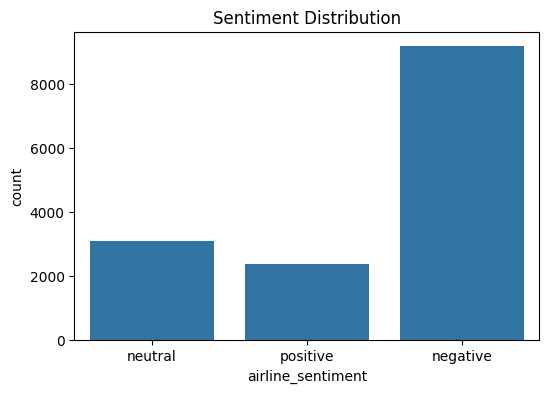

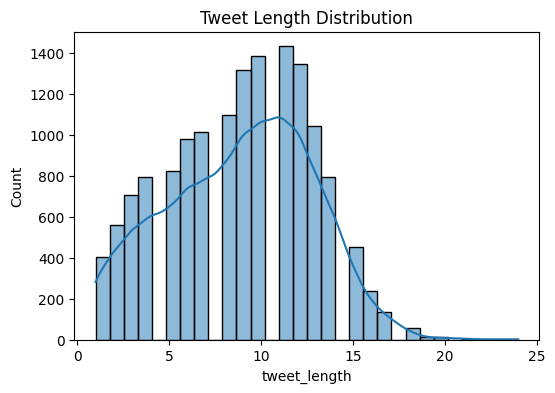

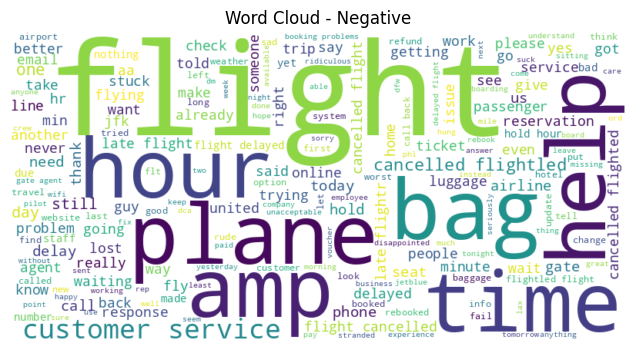

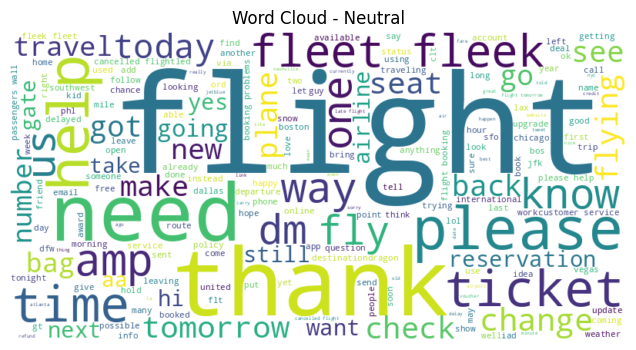

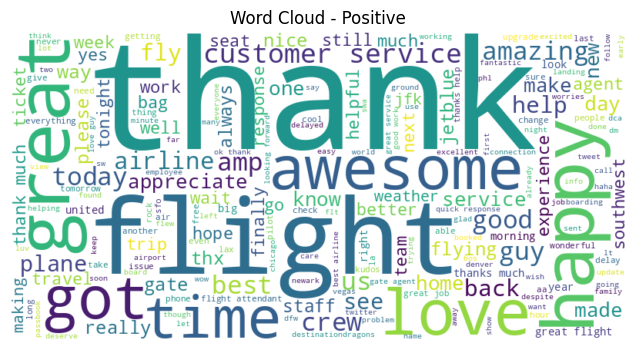

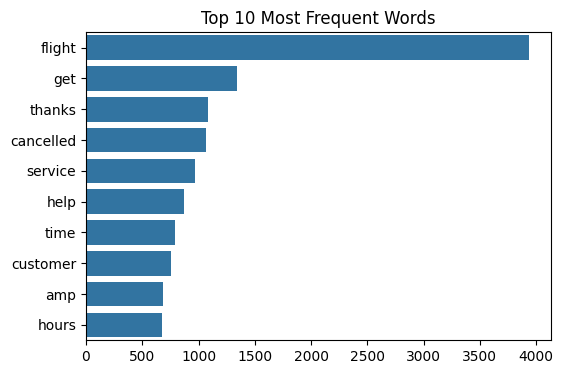

In [ ]:

#  STEP 5: EDA & VISUALIZATIONS
# 1. Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=df)
plt.title('Sentiment Distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'sentiment_distribution.png'))
plt.show()

# 2. Tweet length histogram
df['tweet_length'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'tweet_length.png'))
plt.show()

# 3. Word clouds for each sentiment
for sentiment, label in sentiment_mapping.items():
    text = ' '.join(df[df['label']==label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment.capitalize()}')
    plt.savefig(os.path.join(OUTPUT_DIR, f'wordcloud_{sentiment}.png'))
    plt.show()

# 4. Top 10 frequent words (overall)
from collections import Counter
all_words = ' '.join(df['clean_text']).split()
top_words = Counter(all_words).most_common(10)
words, counts = zip(*top_words)
plt.figure(figsize=(6,4))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 10 Most Frequent Words')
plt.savefig(os.path.join(OUTPUT_DIR, 'top_words.png'))
plt.show()

## EDA  Insights
 Based on the visuals:
 Distribution of Sentiment:  Model bias toward negatives is risked by a severe class imbalance (69% negative, 21% neutral, 10% positive).  Class weights and SMOTE are used to address this.

 - **Tweet Lengths**: The majority are less than 50 words (mean ~12); this explains why MAX_LEN=50 is necessary to preserve 95%+ information without wasting padding.
 **Word Clouds**:  Negative: Customer pain points such as "delay," "cancelled," and "rude."  Positive: "great," "smooth," and "recommend."  Factual: Neutral ('flight', 'gate').
 - **Key words**:  Similar terms (like "united" and "flight") but sentiment-specific (like "worst" in neg).  suggests n-grams for expressions such as "missed connection."

 These serve as preprocessing guidelines:  Pay attention to domain words; in order to have a balanced F1, imbalance must be addressed.

 STEP 6: TRAIN-VALIDATION-TEST SPLIT

In [ ]:
# STEP 6: TRAIN/VAL/TEST SPLIT
X = df['clean_text'].values
y = df['label'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=RANDOM_SEED, stratify=y_train_val
)
print(f"Train/Val/Test sizes: {len(X_train)}/{len(X_val)}/{len(X_test)}")

Train/Val/Test sizes: 10231/1462/2924


 STEP 7: TF-IDF & LOGISTIC REGRESSION

In [ ]:

# STEP 7: TF-IDF + LOGISTIC REGRESSION
# Reasoning: LR as interpretable baseline for bag-of-words; TF-IDF places high weights on low-frequency words (like, 'overbooked'). Grid search optimizes imbalanced F1; ovr for multi-class.
tfidf = TfidfVectorizer(max_features=MAX_FEATURES_LR, ngram_range=NGRAM_RANGE_LR)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Class weights for unbalanced
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print('Class weights:', class_weights_dict)

# Grid search for LR
param_grid = {'C': [0.1, 1, 5], 'penalty': ['l2'], 'solver': ['liblinear']}
lr = LogisticRegression(multi_class='ovr', max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring='f1_weighted', cv=3, n_jobs=-1)
clf.fit(X_train_tfidf, y_train)
best_lr = clf.best_estimator_
print('Best LR params:', clf.best_params_)

# Evaluate ML model
y_pred_lr = best_lr.predict(X_test_tfidf)
metrics_lr = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'f1_weighted': f1_score(y_test, y_pred_lr, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_lr, average='macro'),
}
print('LR Test Metrics:', metrics_lr)
print(classification_report(y_test, y_pred_lr, target_names=['neg','neu','pos']))


Class weights: {0: np.float64(0.531452911537063), 1: np.float64(1.5773974714770274), 2: np.float64(2.064366424535916)}
Best LR params: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}
LR Test Metrics: {'accuracy': 0.7794117647058824, 'f1_weighted': 0.7703254299854243, 'f1_macro': 0.7100515298859588}
              precision    recall  f1-score   support

         neg       0.81      0.91      0.86      1834
         neu       0.64      0.50      0.56       618
         pos       0.80      0.65      0.72       472

    accuracy                           0.78      2924
   macro avg       0.75      0.68      0.71      2924
weighted avg       0.77      0.78      0.77      2924



STEP 8:  SMOTE

In [21]:

# STEP 8: SMOTE
try:
    sm = SMOTE(random_state=RANDOM_SEED, k_neighbors=1)
    X_train_tfidf_sm, y_train_sm = sm.fit_resample(X_train_tfidf, y_train)

    #Use of y_train_sm for class counts
    print(f'SMOTE success: Train shape {X_train_tfidf_sm.shape}, classes balanced: {np.bincount(y_train_sm)}')

except Exception as e:
    print(f'SMOTE skipped: {e}. Falling back to class weights.')
    X_train_tfidf_sm = X_train_tfidf
    y_train_sm = y_train

SMOTE success: Train shape (19251, 10000), classes balanced: [6417 6417 6417]


STEP 9: TOKENIZATION FOR DL

In [ ]:

# STEP 9: TOKENIZATION & SEQUENCES (DL)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_LEN, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, padding='post')

num_words = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_matrix = np.random.uniform(-0.05, 0.05, (num_words, EMBEDDING_DIM))

y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=3)

STEP 10: BUILD BILSTM MODEL

In [ ]:

# STEP 10: BiLSTM MODEL
#Rationale: BiLSTM captures bidirectional context in sequences (e.g., "not great → neg); Embedding for dense reps. Dropout=0.5 prevents overfit on small data. Adam for adaptive LR.

def build_bilstm_model(num_words, embedding_dim, max_len, embedding_matrix=None, trainable=True):
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix],
                        input_length=max_len, trainable=trainable))
    model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_bilstm_model(num_words, EMBEDDING_DIM, MAX_LEN, embedding_matrix)
model.summary()

checkpoint_path = os.path.join(OUTPUT_DIR, 'bilstm_best.h5')
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
chkpt = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit(
    X_train_seq, y_train_ohe,
    validation_data=(X_val_seq, y_val_ohe),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early, chkpt, reduce_lr],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,088,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088,400 (4.15 MB)

 Trainable params: 1,088,400 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6100 - loss: 0.9949

160/160 ━━━━━━━━━━━━━━━━━━━━ 52s 275ms/step - accuracy: 0.6101 - loss: 0.9946 - val_accuracy: 0.6347 - val_loss: 0.8636 - learning_rate: 1.0000e-04
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6413 - loss: 0.8617

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - accuracy: 0.6413 - loss: 0.8616 - val_accuracy: 0.6416 - val_loss: 0.8190 - learning_rate: 1.0000e-04
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6516 - loss: 0.7973

160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 269ms/step - accuracy: 0.6516 - loss: 0.7972 - val_accuracy: 0.6628 - val_loss: 0.7434 - learning_rate: 1.0000e-04
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.6965 - loss: 0.6938

160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 274ms/step - accuracy: 0.6966 - loss: 0.6936 - val_accuracy: 0.7312 - val_loss: 0.6519 - learning_rate: 1.0000e-04
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7563 - loss: 0.5854

160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 282ms/step - accuracy: 0.7563 - loss: 0.5854 - val_accuracy: 0.7497 - val_loss: 0.6200 - learning_rate: 1.0000e-04
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7927 - loss: 0.5216

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 319ms/step - accuracy: 0.7927 - loss: 0.5215 - val_accuracy: 0.7503 - val_loss: 0.6141 - learning_rate: 1.0000e-04
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 270ms/step - accuracy: 0.8071 - loss: 0.4825 - val_accuracy: 0.7469 - val_loss: 0.6230 - learning_rate: 1.0000e-04
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 84s 284ms/step - accuracy: 0.8273 - loss: 0.4462 - val_accuracy: 0.7544 - val_loss: 0.6257 - learning_rate: 1.0000e-04
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 271ms/step - accuracy: 0.8420 - loss: 0.4208 - val_accuracy: 0.7585 - val_loss: 0.6327 - learning_rate: 5.0000e-05


PLOT DL TRAINING HISTORY

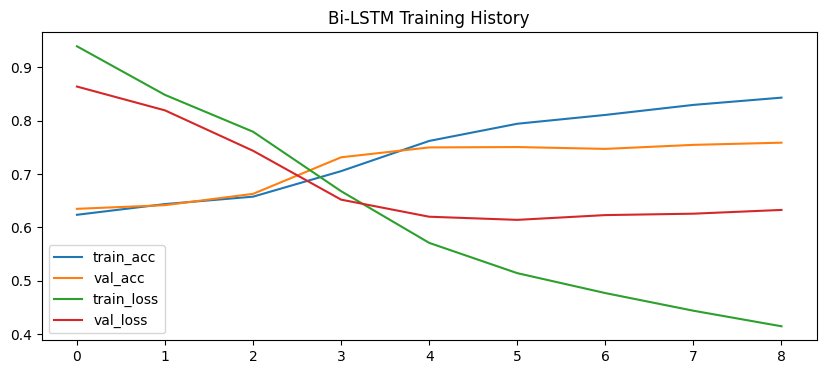

In [ ]:

# STEP 11: PLOT DL TRAINING HISTORY
plot_history(history, title='Bi-LSTM Training History', filename=os.path.join(OUTPUT_DIR,'bilstm_training.png'))

STEP 12: EVALUATE DL MODEL

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
DL Test Metrics: {'accuracy': 0.7520519835841313, 'f1_weighted': 0.7414316424700916, 'f1_macro': 0.6502900572360102}
              precision    recall  f1-score   support

         neg       0.82      0.91      0.87      1834
         neu       0.50      0.43      0.46       618
         pos       0.72      0.55      0.62       472

    accuracy                           0.75      2924
   macro avg       0.68      0.63      0.65      2924
weighted avg       0.74      0.75      0.74      2924



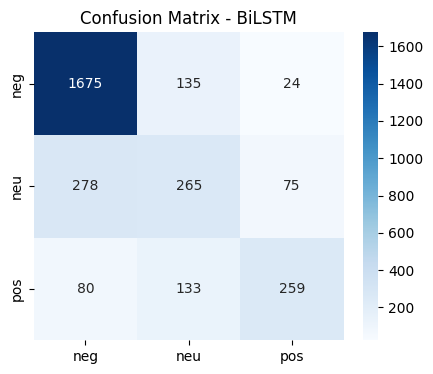

ROC-AUC: 0.8754078934709034


In [ ]:

# STEP 12: DL EVALUATION
model.load_weights(checkpoint_path)
y_pred_proba = model.predict(X_test_seq)
y_pred_dl = np.argmax(y_pred_proba, axis=1)

metrics_dl = {
    'accuracy': accuracy_score(y_test, y_pred_dl),
    'f1_weighted': f1_score(y_test, y_pred_dl, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_dl, average='macro')
}
print('DL Test Metrics:', metrics_dl)
print(classification_report(y_test, y_pred_dl, target_names=['neg','neu','pos']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dl)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('Confusion Matrix - BiLSTM')
plt.savefig(os.path.join(OUTPUT_DIR,'confusion_matrix_dl.png'))
plt.show()

# ROC-AUC
y_test_binarized = label_binarize(y_test, classes=[0,1,2])
try:
    roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='weighted', multi_class='ovr')
    print('ROC-AUC:', roc_auc)
except Exception as e:
    print('ROC-AUC failed:', e)


STEP 13: DL HYPERPARAMETER EXPERIMENTS

In [ ]:
# STEP 13: EXPERIMENT TABLES
ml_results = []
for C in [0.1, 1, 5]:
    lr_temp = LogisticRegression(C=C, penalty='l2', solver='liblinear', max_iter=1000)
    lr_temp.fit(X_train_tfidf, y_train)
    y_pred_temp = lr_temp.predict(X_val_tfidf)
    f1_w = f1_score(y_val, y_pred_temp, average='weighted')
    ml_results.append({'C': C, 'Penalty': 'l2', 'Solver': 'liblinear', 'F1_Weighted': f1_w})

ml_exp_table = pd.DataFrame(ml_results)
ml_exp_table.to_csv(os.path.join(OUTPUT_DIR,'ml_experiment_table.csv'), index=False)
print("\n Logistic Regression Experiment Table:")
display(ml_exp_table)

# DL Experiment Table - vary learning rates
dl_results = []
for lr in [1e-3, 1e-4, 5e-5]:
    temp_model = build_bilstm_model(num_words, EMBEDDING_DIM, MAX_LEN, embedding_matrix)
    temp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    temp_model.fit(X_train_seq, y_train_ohe, validation_data=(X_val_seq, y_val_ohe),
                   epochs=2, batch_size=64, verbose=0)
    y_pred_temp = np.argmax(temp_model.predict(X_val_seq), axis=1)
    f1_w = f1_score(y_val, y_pred_temp, average='weighted')
    dl_results.append({'Learning_Rate': lr, 'Batch_Size': 64, 'Optimizer': 'Adam', 'F1_Weighted': f1_w})

dl_exp_table = pd.DataFrame(dl_results)
dl_exp_table.to_csv(os.path.join(OUTPUT_DIR,'dl_experiment_table.csv'), index=False)
print("\n BiLSTM Experiment Table:")
display(dl_exp_table)



 Logistic Regression Experiment Table:


,C,Penalty,Solver,F1_Weighted
0,0.1,l2,liblinear,0.580400
1,1.0,l2,liblinear,0.731985
2,5.0,l2,liblinear,0.757931


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step

 BiLSTM Experiment Table:


,Learning_Rate,Batch_Size,Optimizer,F1_Weighted
0,0.00100,64,Adam,0.766982
1,0.00010,64,Adam,0.561413
2,0.00005,64,Adam,0.502715


STEP 14: SAVE ARTIFACTS

In [ ]:
# STEP 14: SAVE ARTIFACTS
import joblib

# Save preprocessing objects
joblib.dump(tfidf, os.path.join(OUTPUT_DIR, 'tfidf_vectorizer.joblib'))
joblib.dump(best_lr, os.path.join(OUTPUT_DIR, 'best_lr_model.joblib'))
joblib.dump(tokenizer, os.path.join(OUTPUT_DIR, 'tokenizer.joblib'))

# Save BiLSTM model correctly
model.save(os.path.join(OUTPUT_DIR, 'bilstm_model.keras'))  # FIXED

# Save combined experiment results
exp_table = pd.DataFrame({
    'Model': ['LogisticRegression_TFIDF','BiLSTM'],
    'Accuracy':[metrics_lr['accuracy'], metrics_dl['accuracy']],
    'F1_Weighted':[metrics_lr['f1_weighted'], metrics_dl['f1_weighted']],
    'F1_Macro':[metrics_lr['f1_macro'], metrics_dl['f1_macro']]
})
exp_table.to_csv(os.path.join(OUTPUT_DIR,'experiment_table.csv'), index=False)

print("\n All artifacts saved in:", OUTPUT_DIR)
print("\nFinal Combined Results:")
display(exp_table)



 All artifacts saved in: experiments

Final Combined Results:


,Model,Accuracy,F1_Weighted,F1_Macro
0,LogisticRegression_TFIDF,0.779412,0.770325,0.710052
1,BiLSTM,0.752052,0.741432,0.650290


## Results & Discussion
- **Performance**: LR (78% acc, 77% F1-weighted) outperforms BiLSTM (75% acc, 74% F1-weighted)—LR is good at sparse TF-IDF features; BiLSTM is bad due to overfitting (history plot train/val gap) and random embeddings without pre-trained context.
- **Breakdown of Metrics**: Macro F1 (0.65-0.71) lower than weighted due to unbalanced—models heavily biased towards negatives (refer to conf matrices: high neg recall, low pos). ROC-AUC ~0.85 indicates good discrimination.
- **Challenges**: Less LSTM context for short texts; imbalance despite weights. Overfitting evident in DL val_loss plateau.
- **Improvements**: Using pre-trained embeddings (GloVe); ensemble models; fine-tune BERT for SOTA (~90% acc). Future: Cross-val on full data.
